In [11]:
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, irfft, dct, idct
import cv2
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

import sig_analize as san
import generate_areas as ga
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
dir_path = './drop-250925-1'
img_path_list = [dir_path + '/'+ f for f in os.listdir(dir_path) if f.endswith('.jpg')]
img_path_list.sort()
img_path_list

['./drop-250925-1/160.jpg',
 './drop-250925-1/180.jpg',
 './drop-250925-1/200.jpg',
 './drop-250925-1/220.jpg',
 './drop-250925-1/240.jpg',
 './drop-250925-1/260.jpg',
 './drop-250925-1/280.jpg']

In [73]:
json_path = 'sequence.txt'

ga.choose_multy(img_path_list, json_path, mode='common')

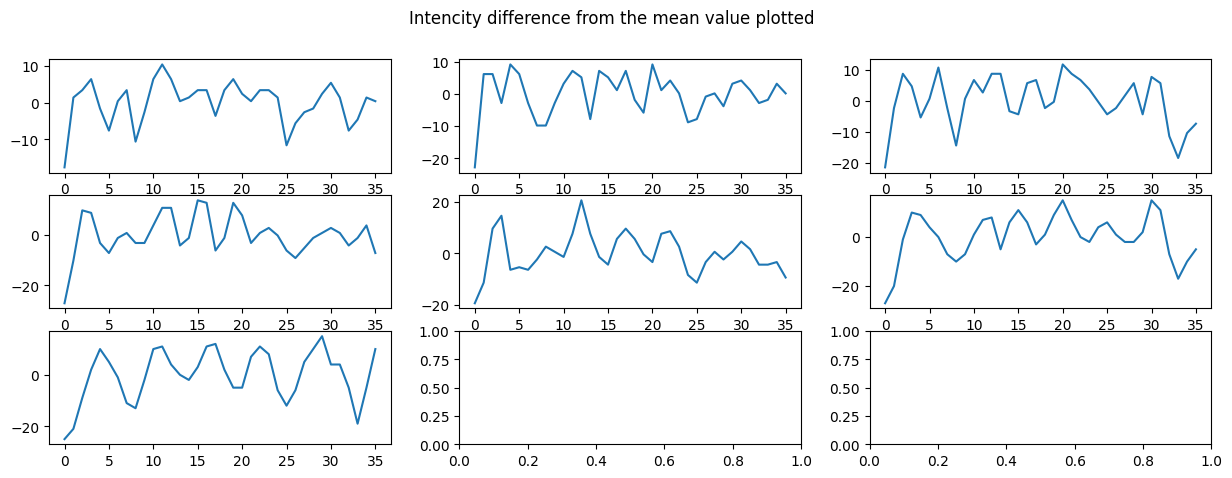

In [74]:
# upload ntencity distributions from json file and
# look at the integral intencity distribution plotted

with open(json_path,'r') as f:
    imgs = json.load(f)[:-1]

img_count = len(imgs)
row_count = (img_count+3-img_count%3)//3

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(imgs[i])
plt.suptitle("Intencity difference from the mean value plotted")
plt.show()

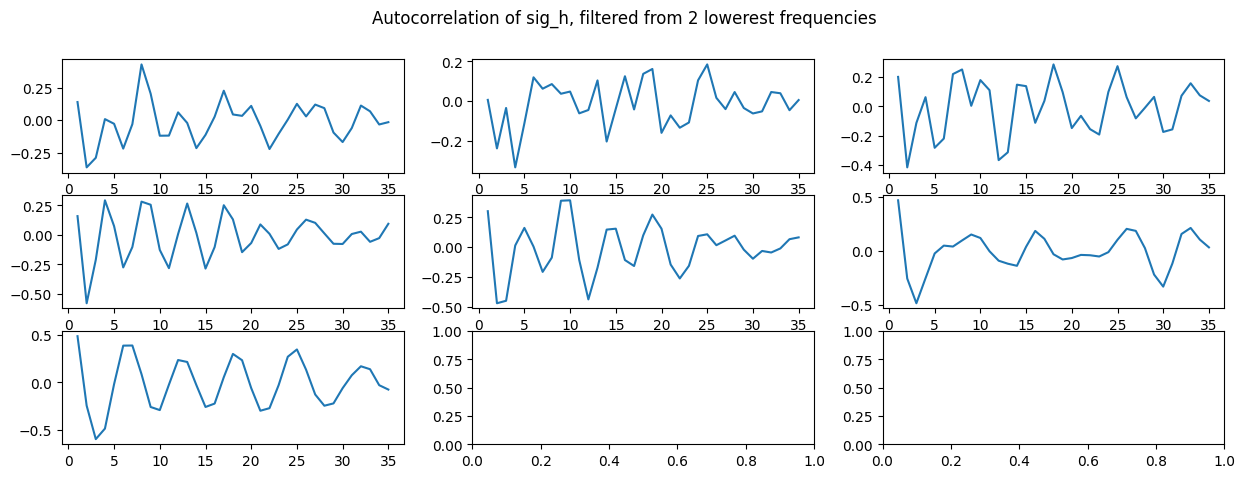

In [77]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
sig_len = len(imgs[0])  # for mode='commom' length is the same for all signals

fs=1
nl = 2
f_min = nl/sig_len
border = 4

bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
sig_h = [signal.filtfilt(bh, ah, img, method='gust') for img in imgs]

cor_res =  [san.auto_corr(sig, sig_len, dt=1) for sig in sig_h]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))
for i in range(img_count):
    ax[i//3][i%3].plot(*cor_res[i])
plt.suptitle(f"Autocorrelation of sig_h, filtered from {nl} lowerest frequencies")
plt.show()

In [78]:
# counting peaks in original signal

peak_count = [san.peak_counter(sig)[0] for sig in sig_h]
print(peak_count)

[8, 10, 8, 8, 9, 6, 6]


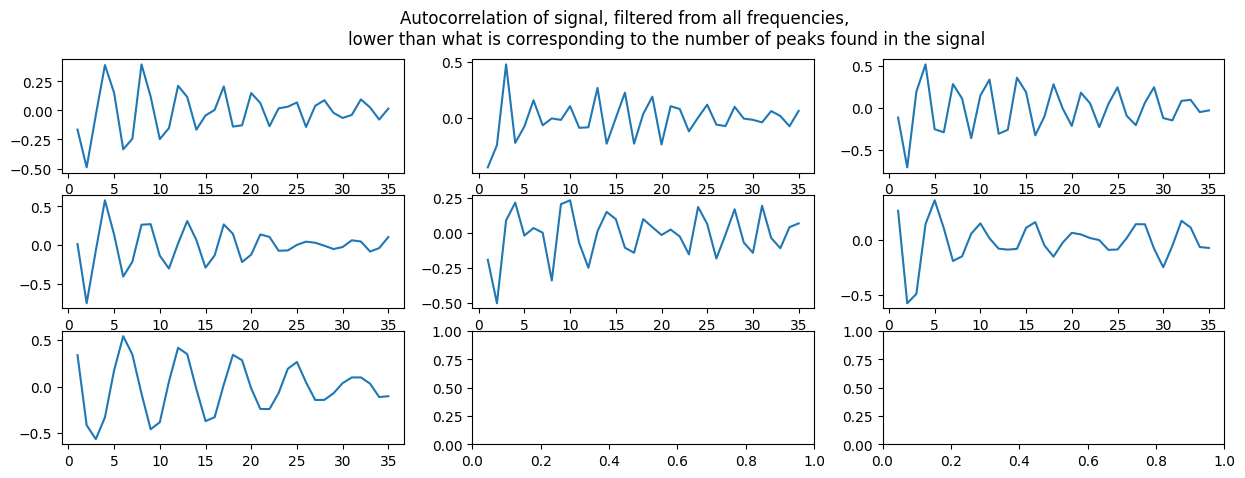

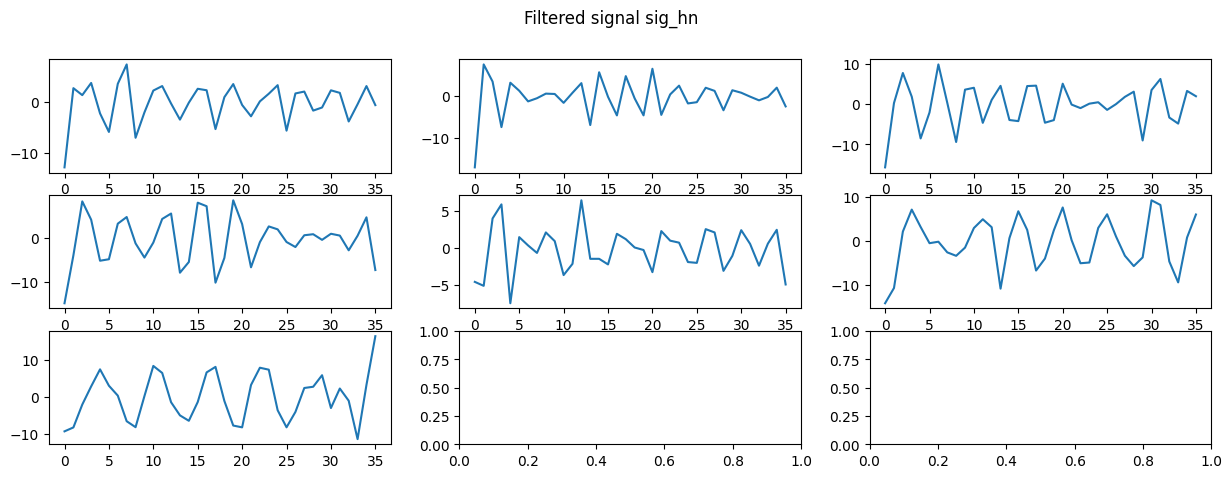

In [89]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
# !!! here we use nl = number of peaks in autocorrelation function

fs = 1
border = 4

sig_hn = []

for i in range(img_count):
    nl = peak_count[i]-1
    f_min = nl/sig_len


    bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
    sig_hn.append(signal.filtfilt(bh, ah, sig_h[i], method='gust'))


fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))
for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_hn[i], sig_len, dt=1/fs))
plt.suptitle("Autocorrelation of signal, filtered from all frequencies,\n\
                lower than what is corresponding to the number of peaks found in the signal")
plt.show()

sig_x = np.arange(sig_len)

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))
for i in range(img_count):
    ax[i//3][i%3].plot(sig_x, sig_hn[i])
plt.suptitle("Filtered signal sig_hn")
plt.show()

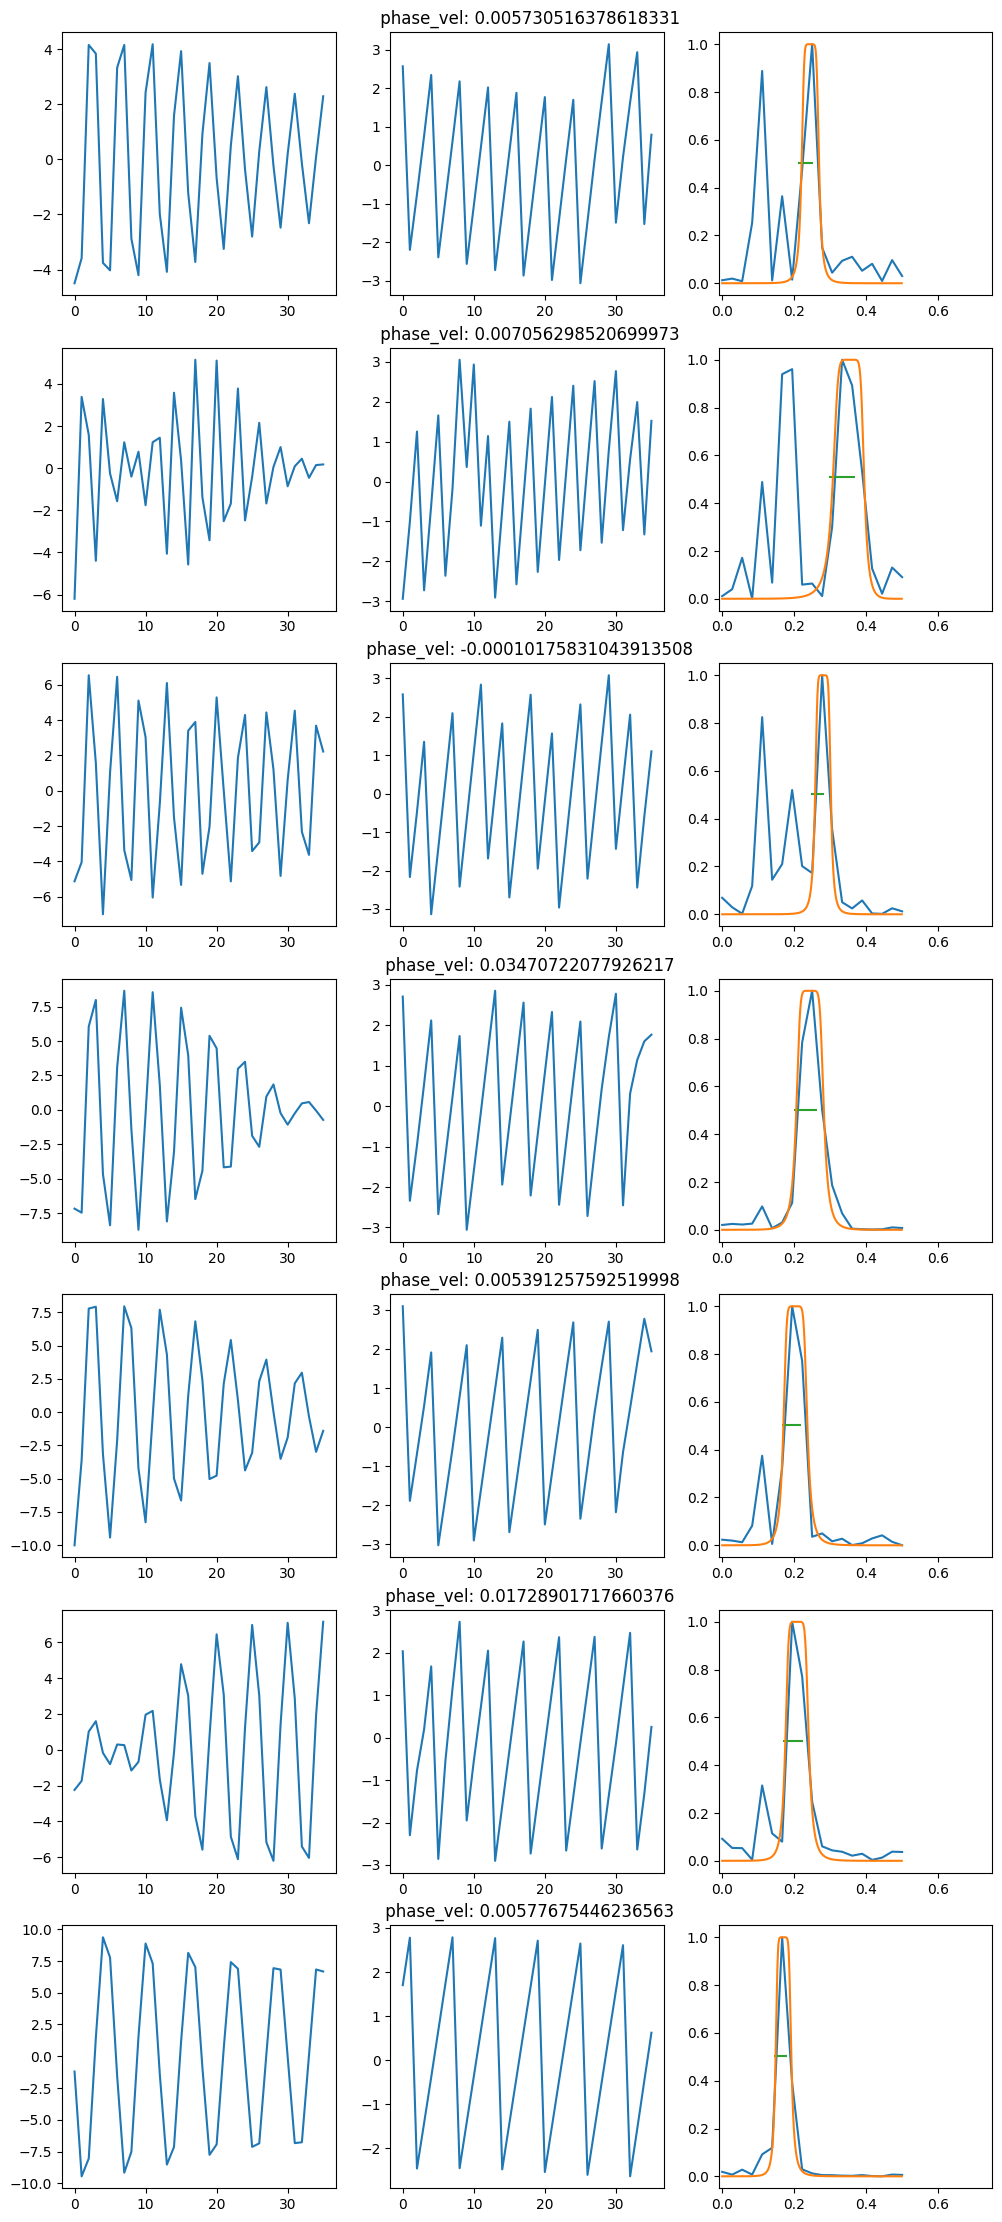

In [93]:
ph_vel_hn = san.plot_flt_res(sig_h, fs=1, rel_h=0.5, nperseg_c=1)

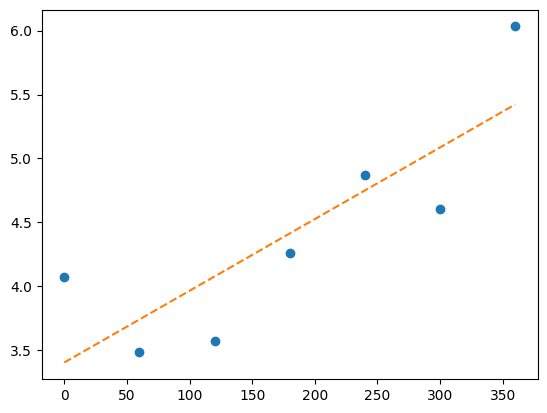

In [81]:
time = np.arange(img_count)*3*20

slope, intercept = np.polyfit(time, 1/np.array(ph_vel_hn), 1)
phase_vel_line = time*slope + intercept

plt.figure()
plt.plot(time, 1/np.array(ph_vel_hn), 'o')
plt.plot(time, phase_vel_line, '--')

Next we will try to approximate the filtered signal with cosinusoids using descrete fourie transform
and repeat the same analisis for smoothed signal

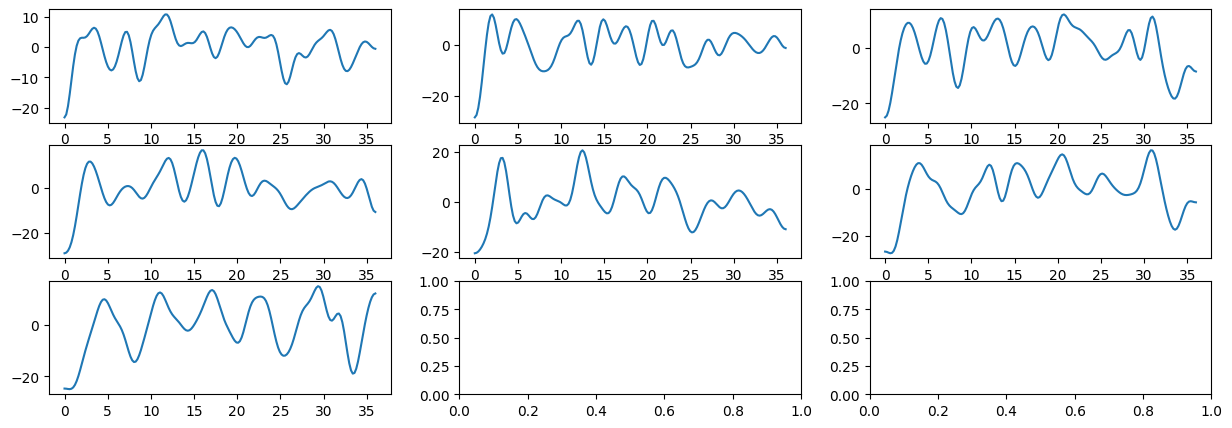

In [91]:
# approximate the graphssig_hn  with sums of cosinusoids using dct
# and plot the smoother versions 

N = sig_len*5
fs = N/sig_len

coeffs = [dct(sig) for sig in imgs]
sig_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_sm[i])

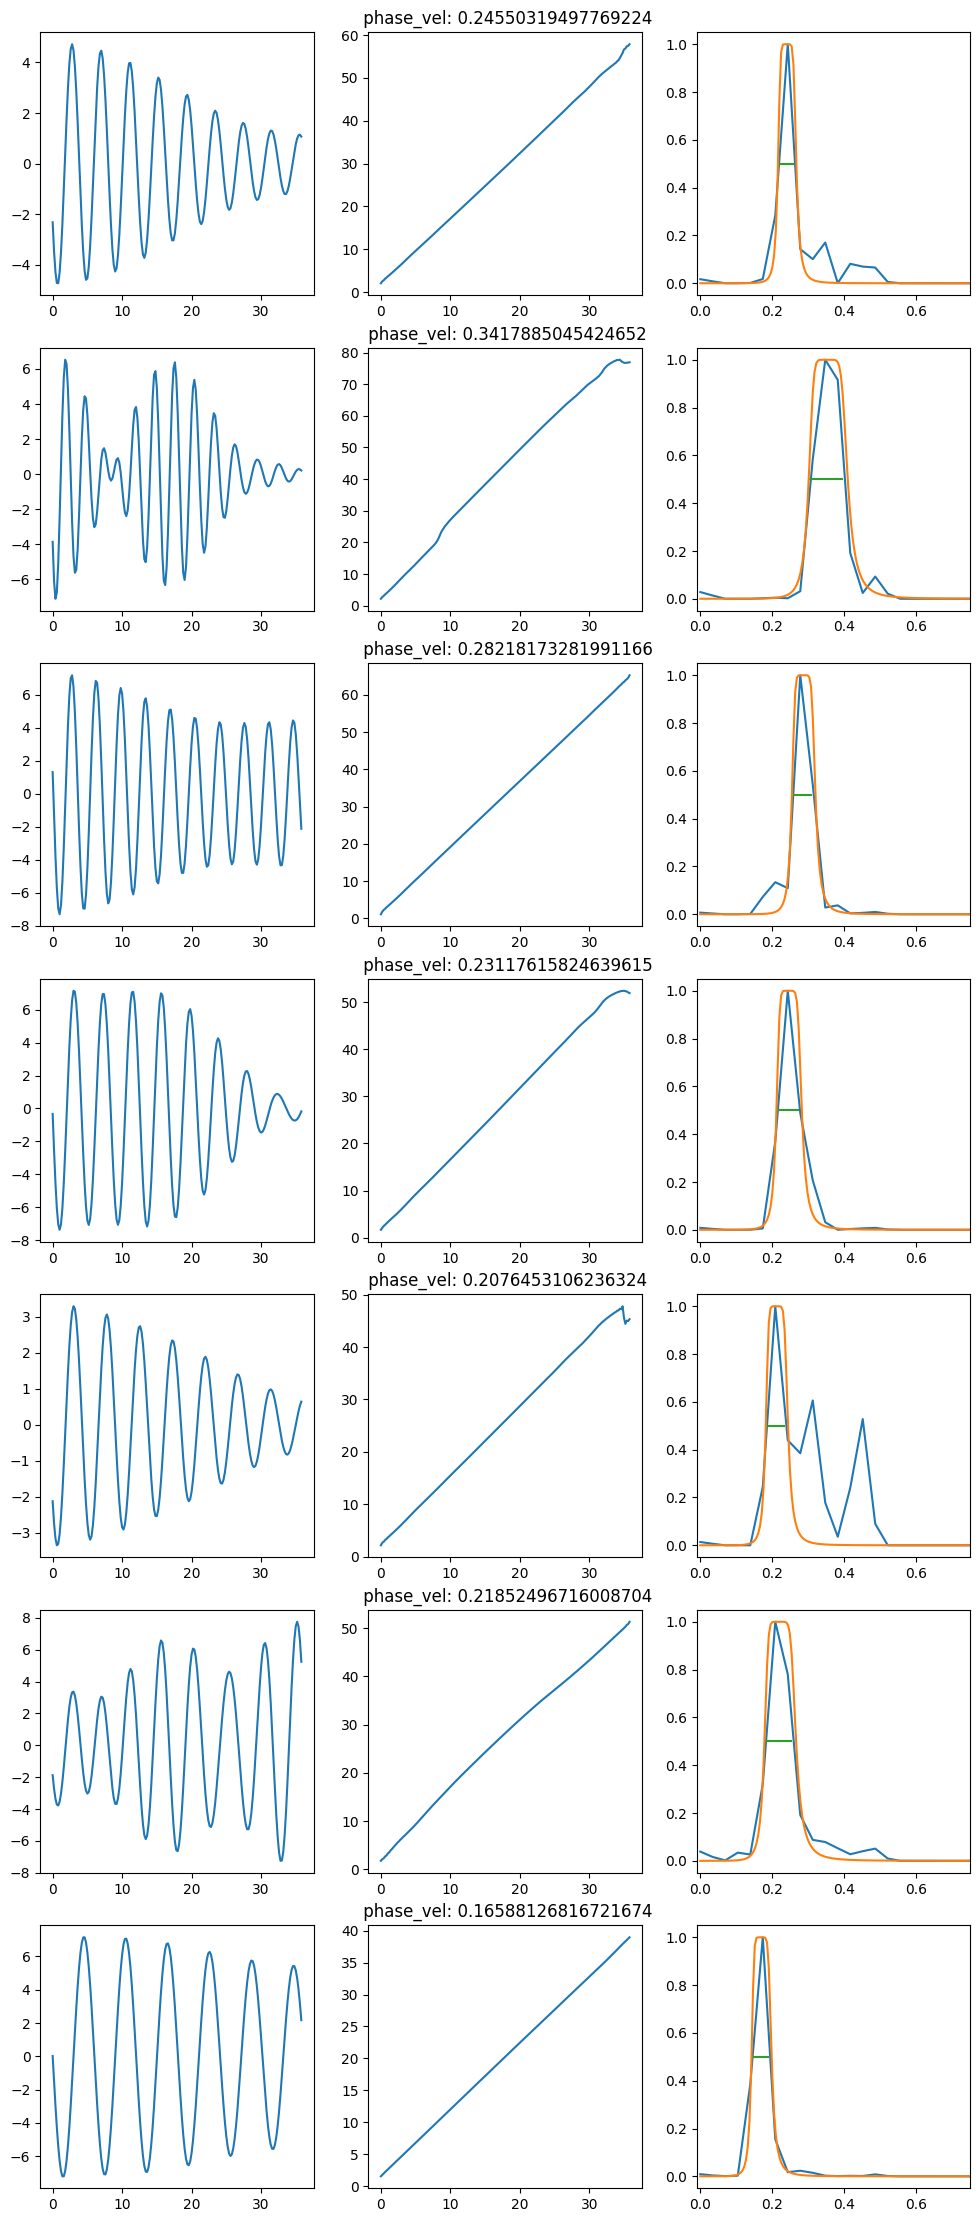

In [92]:
# filtering smoothed signals with san.my_butter and plot filtered signal
# applying signal.hilbert to the filtered signal and plot instant phase
# plot spectral density destribution and filter responce to monitor

fs = N/sig_len
sig_y = [s[1] for s in sig_hn_sm] 

ph_v = san.plot_flt_res(sig_y, fs=fs, rel_h=0.5, nperseg_c=0.8)

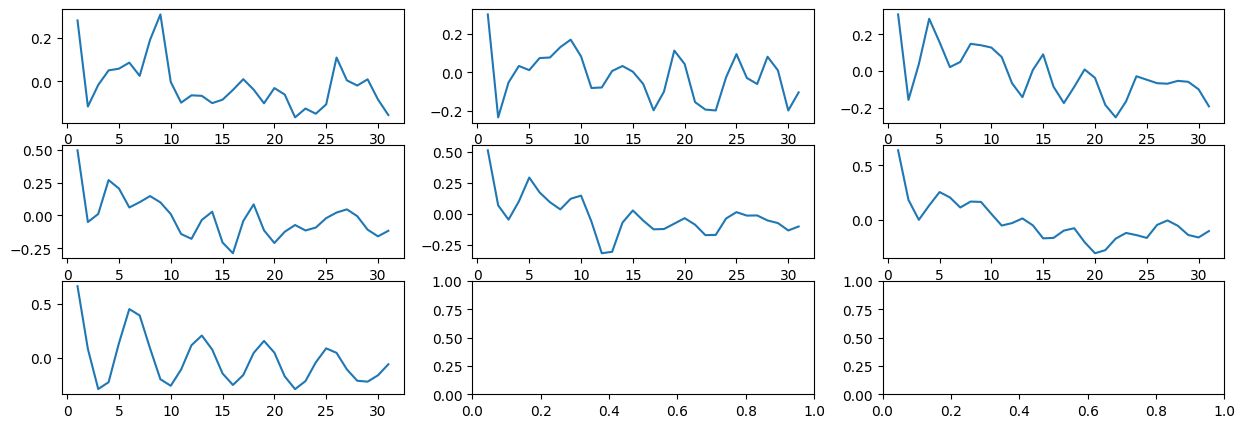

In [14]:
# Let's look at autocorrelation functions of original signals
sig_y = [s[1] for s in sig_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(imgs[i], sig_len, dt=1))

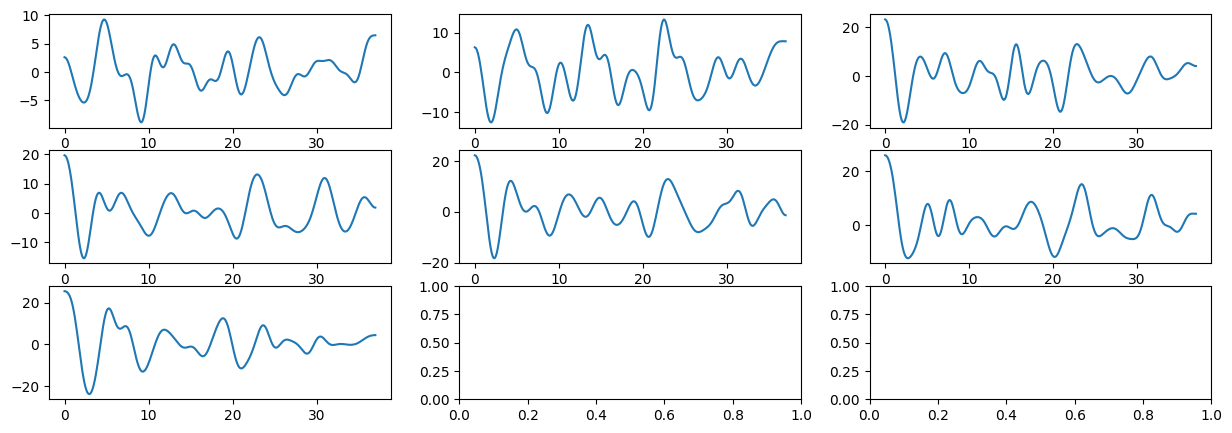

In [10]:
N = 300
fs = N/sig_len

coeffs = [dct(sig) for sig in sig_h]
sig_h_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_h_sm[i])

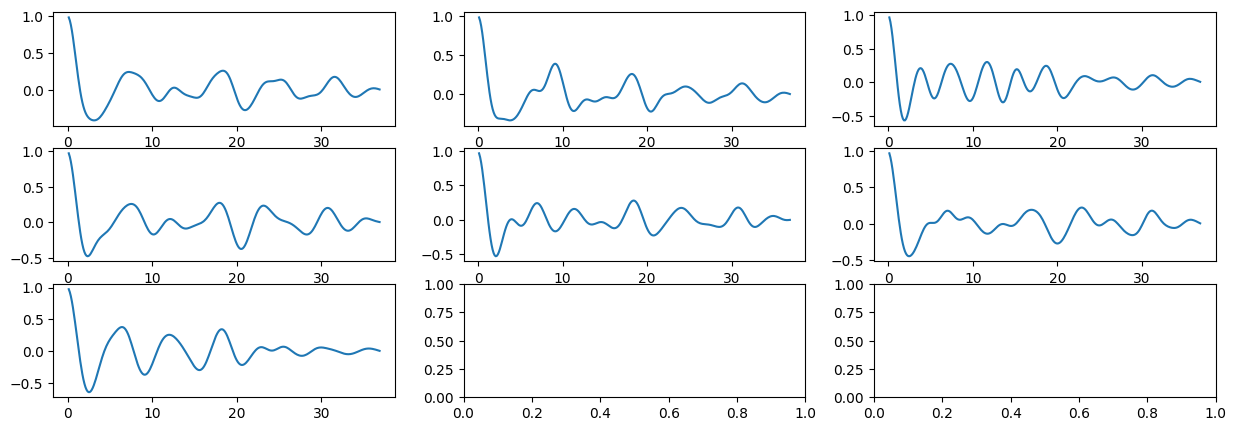

In [11]:
sig_h_sm_y = [s[1] for s in sig_h_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

cor_res =  [san.auto_corr(sig_h_sm_y[i], N, dt=1/fs) for i in range(img_count)]

for i in range(img_count):
    ax[i//3][i%3].plot(*cor_res[i])

In [12]:
peak_counts = [san.peak_counter(cor[1])[0] for cor in cor_res]
print(peak_counts)

[6, 8, 9, 6, 8, 9, 7]


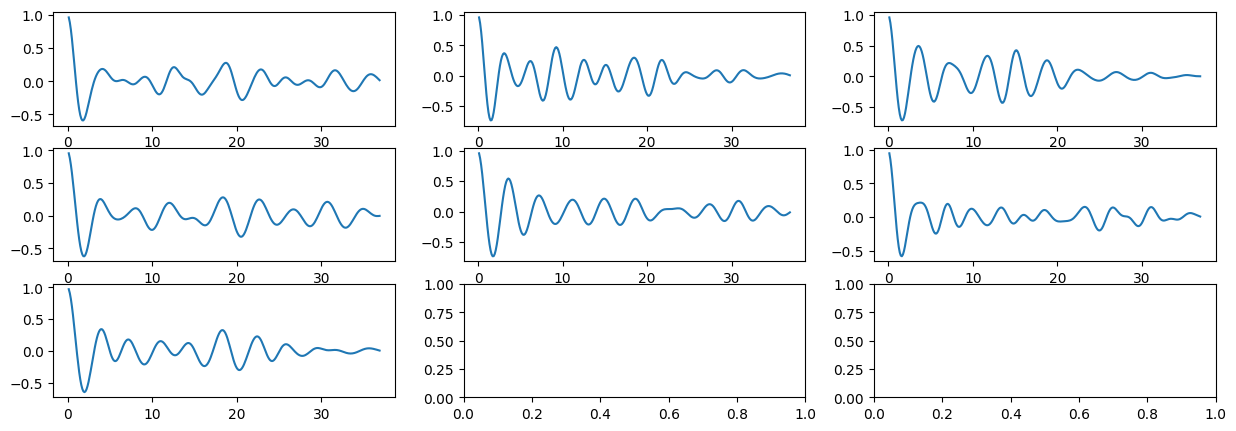

In [13]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
# !!! here we use nl = number of peaks in autocorrelation function
N = 300
fs = N/sig_len
border = 4

sig_h = []

for i in range(img_count):
    nl = peak_counts[i]
    f_min = nl/sig_len


    bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
    sig_h.append(signal.filtfilt(bh, ah, sig_h_sm_y[i], method='gust'))

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_h[i], N, dt=1/fs))

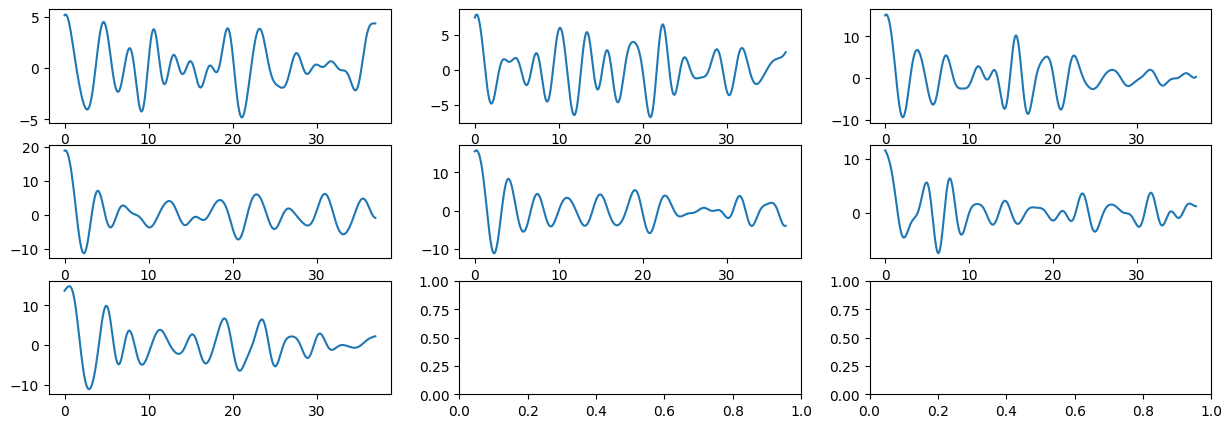

In [14]:
fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(sig_h_sm[0][0], sig_h[i])



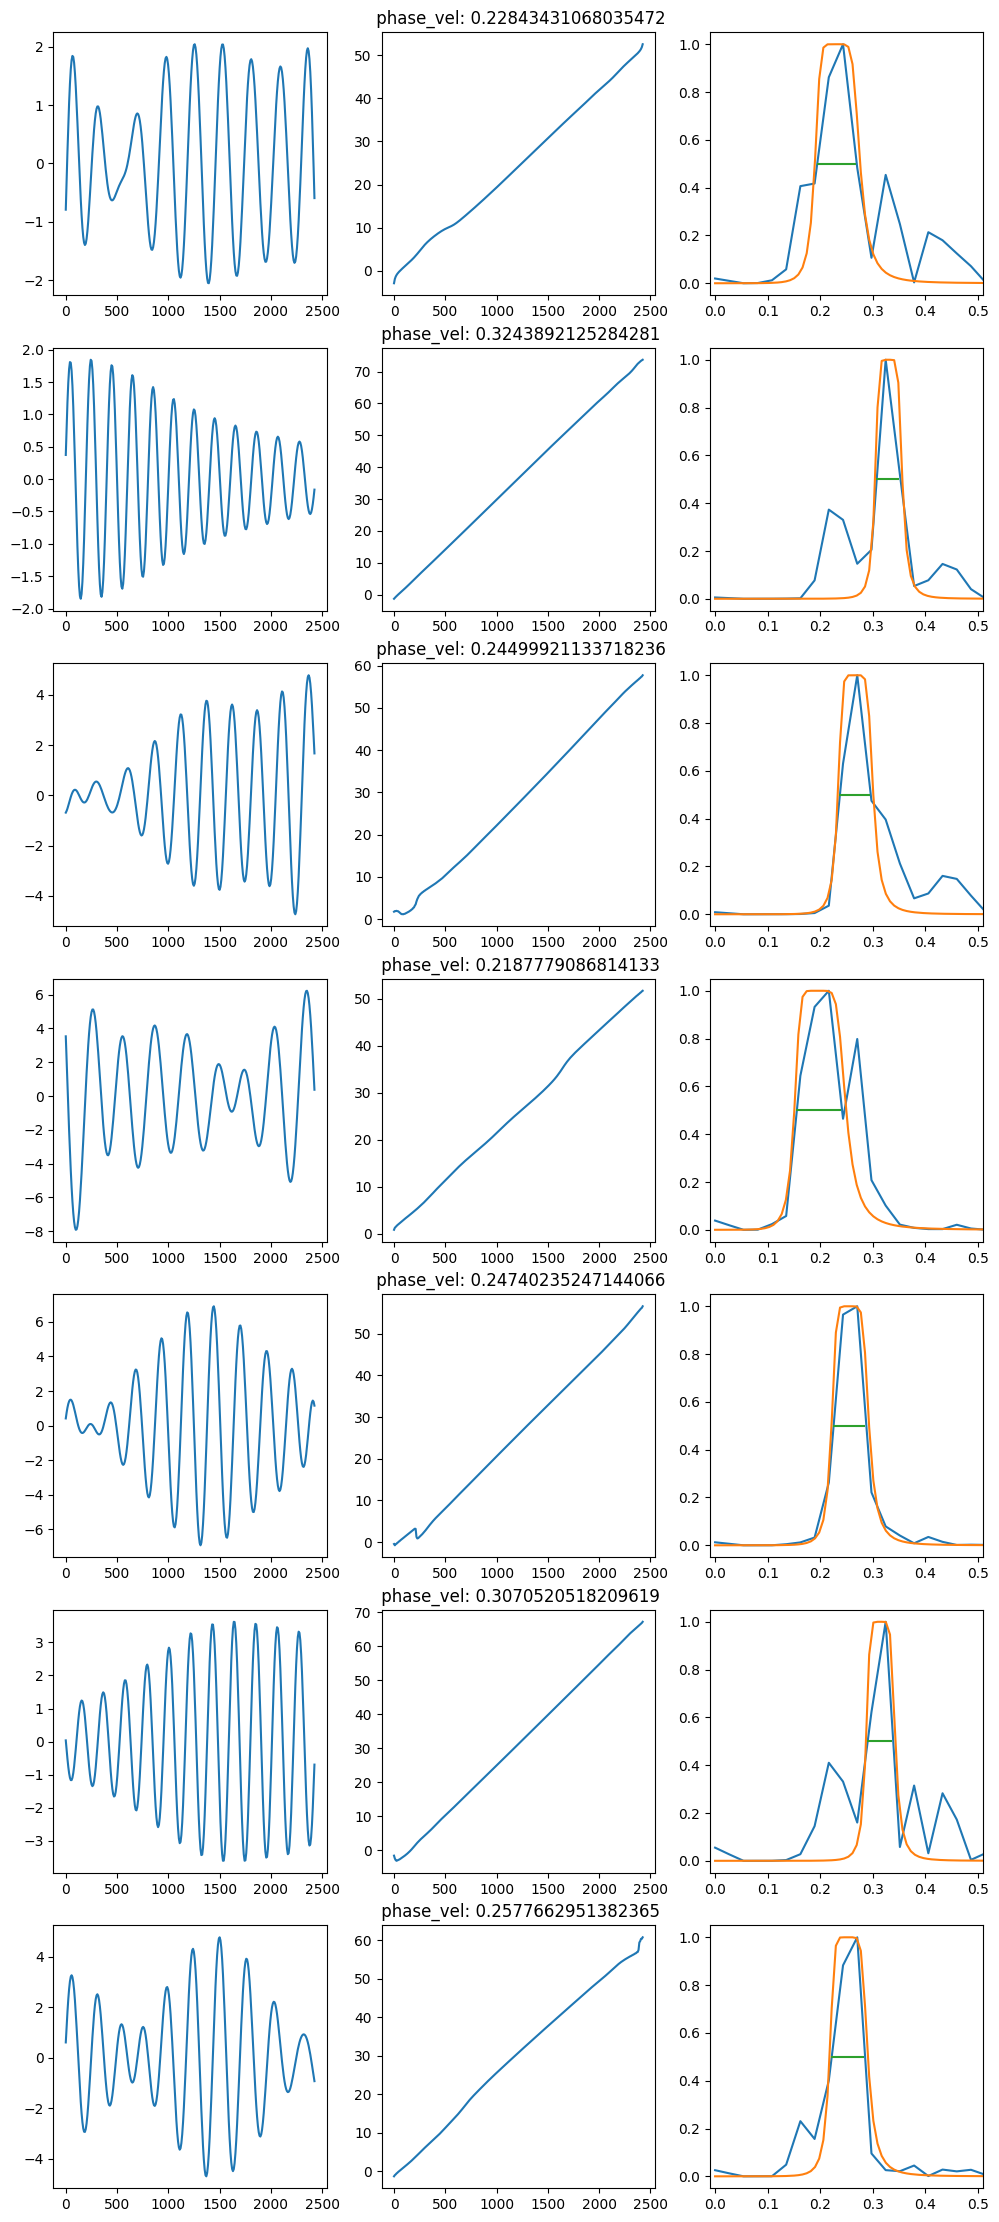

In [15]:
N = 300
fs = N/sig_len
phase_vel = plot_flt_res(sig_h, fs=fs, rel_h=0.5, nperseg_c=1)

In [85]:
print(slope)

-0.0004967711580463839
